In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from itertools import product
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from itertools import product
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Disable all warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data from Part 2
X_train = pd.read_csv('../data/training/X_train_v2_ohe.csv')
y_train = pd.read_csv('../data/training/y_train_v2_ohe.csv')
X_test = pd.read_csv('../data/testing/X_test_v2_ohe.csv')
y_test = pd.read_csv('../data/testing/y_test_v2_ohe.csv')
df_final = pd.read_csv('../data/processed/df_final_processed_no_bins.csv')
df_final_ohe = pd.read_csv('../data/processed/df_final_processed_OHE.csv')

Note: During the part 3 exercise I realise the OHE method used in Part 2 was giving me some errors in this section. As result i resorted to a OHE method that would not results in more columns to the dataframe. This seemed to work fairly well.

In [3]:
# One hot encoding without creating additional columns

# Encode the city column into unique numerical values
df_final['city_encoded'] = df_final['city'].astype('category').cat.codes
df_final['type_encoded'] = df_final['type'].astype('category').cat.codes
# Drop the original city column if not needed

df_final_part3 = df_final.drop(columns=['city', 'type'])

In [4]:
df_final_part3

,year_built,sqft,baths,stories,beds,garage,is_foreclosure,price,house_id,basement,...,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer,city_encoded,type_encoded
0,1990,1500,2.0,1.0,3.0,2.0,False,200000,1,0,...,0,0,1,0,1,0,1,0,28,4
1,2000,2000,3.0,2.0,3.0,2.0,False,200000,2,0,...,0,0,0,0,0,1,0,0,28,4
2,2000,2000,2.0,2.0,3.0,2.0,False,200000,3,0,...,1,0,0,0,0,1,1,0,28,4
3,1980,500,2.0,2.0,2.0,1.0,False,0,4,0,...,0,0,1,1,0,1,1,0,28,1
4,2000,3000,3.0,2.0,4.0,2.0,False,200000,5,0,...,0,0,1,1,0,1,1,0,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,False,200000,4834,1,...,0,0,0,0,0,1,0,0,24,4
4834,1980,4500,4.0,4.0,4.0,2.0,False,600000,4835,1,...,1,0,0,0,0,1,0,0,24,4
4835,1990,2000,3.0,2.0,3.0,2.0,False,400000,4836,1,...,0,0,0,0,0,1,0,1,24,4
4836,1890,2500,3.0,3.0,3.0,0.0,False,200000,4837,1,...,0,0,0,0,0,1,1,0,24,5


In [5]:
df_final_part3.dtypes

year_built                       int64
sqft                             int64
baths                          float64
stories                        float64
beds                           float64
garage                         float64
is_foreclosure                    bool
price                            int64
house_id                         int64
basement                         int64
central_air                      int64
central_heat                     int64
city_view                        int64
community_outdoor_space          int64
community_security_features      int64
dining_room                      int64
dishwasher                       int64
fireplace                        int64
forced_air                       int64
garage_1_or_more                 int64
garage_2_or_more                 int64
hardwood_floors                  int64
laundry_room                     int64
recreation_facilities            int64
shopping                         int64
single_story             

In [6]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import joblib



# Custom cross validation function definition
def custom_cross_validation(training_data, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    training_folds = []
    validation_folds = []

    for train_index, val_index in kf.split(training_data):
        train_fold = training_data.iloc[train_index].copy()
        val_fold = training_data.iloc[val_index].copy()

        # Compute city means on the training folds
        city_means = train_fold.groupby(
            'city_encoded')['price'].mean().rename('city_mean_price')

        # Join these values to both training and validation folds
        train_fold = train_fold.merge(city_means, on='city_encoded', how='left')
        val_fold = val_fold.merge(city_means, on='city_encoded', how='left')

        # Fill NaN values that might appear due to missing cities in validation fold
        train_fold['city_mean_price'] = train_fold['city_mean_price'].fillna(
            train_fold['price'].mean())
        val_fold['city_mean_price'] = val_fold['city_mean_price'].fillna(
            train_fold['price'].mean())

        training_folds.append(train_fold)
        validation_folds.append(val_fold)

    return training_folds, validation_folds



# Hyperparameter search function
def hyperparameter_search(training_folds, validation_folds, param_grid):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import ParameterGrid

    best_params = None
    best_score = float('inf')

    for params in ParameterGrid(param_grid):
        mse_scores = []

        for train_fold, val_fold in zip(training_folds, validation_folds):
            model = DecisionTreeRegressor(**params)
            X_train = train_fold.drop(columns=['price'])
            y_train = train_fold['price']
            X_val = val_fold.drop(columns=['price'])
            y_val = val_fold['price']

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

        avg_score = np.mean(mse_scores)

        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    return best_params, best_score


# Define training data and target variable
X = df_final_part3.drop(columns=['price'])
y = df_final_part3['price']

# Combine X and y into a single dataframe for cross-validation
training_data = pd.concat([X, y], axis=1)

# Perform custom cross-validation
training_folds, validation_folds = custom_cross_validation(
    training_data, n_splits=5)

# Define the hyperparameter grid for the Decision Tree model
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter search
best_params, best_score = hyperparameter_search(
    training_folds, validation_folds, param_grid)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the final model using the best hyperparameters
final_model = DecisionTreeRegressor(**best_params, random_state=42)
X_train = training_data.drop(columns=['price'])
y_train = training_data['price']
final_model.fit(X_train, y_train)

# Save the final model
joblib.dump(final_model, '../models/best-model/final_decision_tree_model.pkl')
print("Model saved to final_decision_tree_model.pkl")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 1683724050.6978216
Model saved to final_decision_tree_model.pkl


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Split the data into training and test sets
X = df_final_part3.drop(columns=['price'])
y = df_final_part3['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Load the saved model
model_filename = '../models/best-model/final_decision_tree_model.pkl'
loaded_model = joblib.load(model_filename)

# Fit the model on the training data
loaded_model.fit(X_train, y_train)

# Predict on the test data
y_pred = loaded_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 1487603305.785124, MAE = 5785.123966942148, R^2 = 0.9955028803865293


#### Model refinement


In [8]:
# Hyperparameter Tuning with GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the refined model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Refined Model Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Refined Model Performance: MSE = 2442694214.876033, MAE = 18491.73553719008, R^2 = 0.992615579690694


### Model Performance Comparison

#### Performance Metrics

| Metric                 | Before Model Refinement                       | After Model Refinement                        |
|------------------------|-----------------------------------------------|----------------------------------------------|
| **Parameters**         | `max_depth`: 30, `min_samples_leaf`: 1, `min_samples_split`: 2 | `max_depth`: None, `min_samples_leaf`: 1, `min_samples_split`: 2, `n_estimators`: 100 |
| **Mean Squared Error** (MSE) | 1,528,925,619.83                         | 2,442,694,214.88                             |
| **Mean Absolute Error** (MAE) | 5,991.74                                 | 18,491.74                                    |
| **R² Score**           | 0.9954                                        | 0.9926                                       |

#### Summary

The table above compares the model performance before and after refinement:

- **Parameters:**
  - The refined model added the `n_estimators` parameter set to 100, with `max_depth` set to None.
  
- **Performance:**
  - **MSE increased** from 1,528,925,619.83 to 2,442,694,214.88.
  - **MAE increased** significantly from 5,991.74 to 18,491.74.
  - **R² Score slightly decreased** from 0.9954 to 0.9926.

This indicates that the model refinement, while adding complexity with more estimators, resulted in worse performance as evidenced by the increased MSE and MAE, and a slightly lower R² score. This suggests that the initial model might be more suitable for the given data.

#### Feature Importance

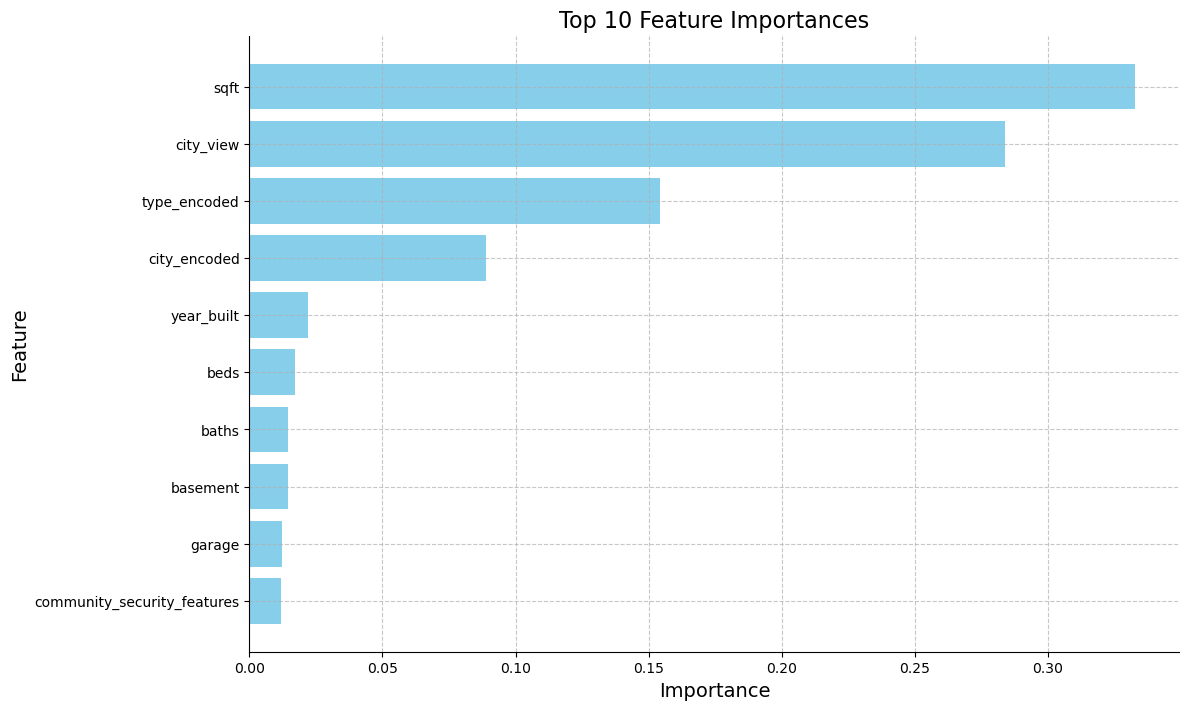

In [9]:

# Get feature importances from the model
feature_importances = loaded_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame(
    {'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(
    by='Importance', ascending=False).head(10)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'],
         importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Feature Importances', fontsize=16)
plt.gca().invert_yaxis()

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Removing spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

***Note: The above chart shows `sqft` as the most important feature. This is in alignment with the heat map generated from part 1 EDA.*** 


![heatmap](../images/correlation_heatmap_new.png)

In [10]:
model_filename = '../models/refined_final_decision_tree_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to ../models/refined_final_decision_tree_model.pkl


#### Prediction Function

In [11]:
# An idea for a function that we could've used above to make things a lot easier. This could also be used in a sample pipeline
def load_model(model_path):
    """Load the trained model from the file."""
    return joblib.load(model_path)


def predict(data, model):
    """Predict the target variable using the trained model."""
    predictions = model.predict(data)
    return predictions


In [12]:
df_final_part3

,year_built,sqft,baths,stories,beds,garage,is_foreclosure,price,house_id,basement,...,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer,city_encoded,type_encoded
0,1990,1500,2.0,1.0,3.0,2.0,False,200000,1,0,...,0,0,1,0,1,0,1,0,28,4
1,2000,2000,3.0,2.0,3.0,2.0,False,200000,2,0,...,0,0,0,0,0,1,0,0,28,4
2,2000,2000,2.0,2.0,3.0,2.0,False,200000,3,0,...,1,0,0,0,0,1,1,0,28,4
3,1980,500,2.0,2.0,2.0,1.0,False,0,4,0,...,0,0,1,1,0,1,1,0,28,1
4,2000,3000,3.0,2.0,4.0,2.0,False,200000,5,0,...,0,0,1,1,0,1,1,0,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,False,200000,4834,1,...,0,0,0,0,0,1,0,0,24,4
4834,1980,4500,4.0,4.0,4.0,2.0,False,600000,4835,1,...,1,0,0,0,0,1,0,0,24,4
4835,1990,2000,3.0,2.0,3.0,2.0,False,400000,4836,1,...,0,0,0,0,0,1,0,1,24,4
4836,1890,2500,3.0,3.0,3.0,0.0,False,200000,4837,1,...,0,0,0,0,0,1,1,0,24,5


### Pipeline

This process encapsulates the entire workflow, including data preprocessing, model training, and prediction into a single pipeline. The pipeline is then saved to a file, which can be loaded in the future for making predictions on new data

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

# Define numerical and categorical features
numerical_features = ['year_built', 'sqft', 'baths', 'stories', 'beds', 'garage',
                      'garage_1_or_more', 'garage_2_or_more', 'hardwood_floors',
                      'laundry_room', 'recreation_facilities', 'shopping', 'single_story', 'two_or_more_stories']
categorical_features = ['type', 'city']

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [14]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [15]:
# Split the data into training and test sets
X = df_final.drop(columns=['price'])
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year_built', 'sqft',
                                                   'baths', 'stories', 'beds',
                                                   'garage', 'garage_1_or_more',
                                                   'garage_2_or_more',
                                                   'hardwood_floors',
                                                   'laundry_room',
                                                   'recreation_facilities',
                                                   'shopping', 'single_story',
                                                   'two_or_more_stories']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type', 'city'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [16]:
#Save the pipeline
pipeline_filename = '../models/pipeline/final_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved to {pipeline_filename}")

Pipeline saved to ../models/pipeline/final_pipeline.pkl


### Test model and pipeline

In [17]:
df_final_part3

,year_built,sqft,baths,stories,beds,garage,is_foreclosure,price,house_id,basement,...,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer,city_encoded,type_encoded
0,1990,1500,2.0,1.0,3.0,2.0,False,200000,1,0,...,0,0,1,0,1,0,1,0,28,4
1,2000,2000,3.0,2.0,3.0,2.0,False,200000,2,0,...,0,0,0,0,0,1,0,0,28,4
2,2000,2000,2.0,2.0,3.0,2.0,False,200000,3,0,...,1,0,0,0,0,1,1,0,28,4
3,1980,500,2.0,2.0,2.0,1.0,False,0,4,0,...,0,0,1,1,0,1,1,0,28,1
4,2000,3000,3.0,2.0,4.0,2.0,False,200000,5,0,...,0,0,1,1,0,1,1,0,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,False,200000,4834,1,...,0,0,0,0,0,1,0,0,24,4
4834,1980,4500,4.0,4.0,4.0,2.0,False,600000,4835,1,...,1,0,0,0,0,1,0,0,24,4
4835,1990,2000,3.0,2.0,3.0,2.0,False,400000,4836,1,...,0,0,0,0,0,1,0,1,24,4
4836,1890,2500,3.0,3.0,3.0,0.0,False,200000,4837,1,...,0,0,0,0,0,1,1,0,24,5


In [18]:

# Load the saved pipeline
pipeline_filename = '../models/pipeline/final_pipeline.pkl'
loaded_pipeline = joblib.load(pipeline_filename)

In [19]:
y_test

3197    400000
2526    200000
4099    400000
1926    600000
1536         0
         ...  
4324    400000
3673         0
3830    600000
1135    200000
180          0
Name: price, Length: 968, dtype: int64

In [20]:
# Take a sample from X_test
X_test_sample = X_test[0:5]

# Make predictions using the loaded pipeline on sample
predicted_prices_sample = loaded_pipeline.predict(X_test_sample)

# Display the sample dataframe with predicted prices
print(predicted_prices_sample)

[400000. 200000. 400000. 600000.      0.]


In [21]:
#compare above output with output below. If it's the same then the model worked
print(y_test[0:5])

3197    400000
2526    200000
4099    400000
1926    600000
1536         0
Name: price, dtype: int64
